In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from data_utils import get_id_type_list_from_annotations
from image_utils import get_image_data

In [4]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print("Number of hand-made annotations: ", len(annotations))

trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix', 'ok'])
bad_id_type_list = get_id_type_list_from_annotations(annotations, select=['to_remove', ])
print(len(trainval_id_type_list), len(bad_id_type_list))

## Remove green imagery
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)
print(len(trainval_id_type_list))

Number of hand-made annotations:  4483
2839 1644
2821


In [5]:
import numpy as np
from data_utils import compute_type_distribution
compute_type_distribution(np.array(trainval_id_type_list))

[0.32825239276852181, 0.33002481389578164, 0.34172279333569655]

In [6]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
    cache = DataCache(0)

In [7]:
os.environ['KERAS_BACKEND']='tensorflow'

from custom_vgg_bn import get_custom_vgg_bn

Using TensorFlow backend.


In [8]:
from keras import backend as K
print(K.backend(), K.image_dim_ordering())

tensorflow tf


In [15]:
vgg = get_custom_vgg_bn()
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
vgg_preprocess_1 (Lambda)        (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1_1 (Conv2D)          (None, 224, 224, 64)  1792                                         
____________________________________________________________________________________________________
block1_conv2_1 (Conv2D)          (None, 224, 224, 64)  36928                                        
___________________________________________________________________________________________

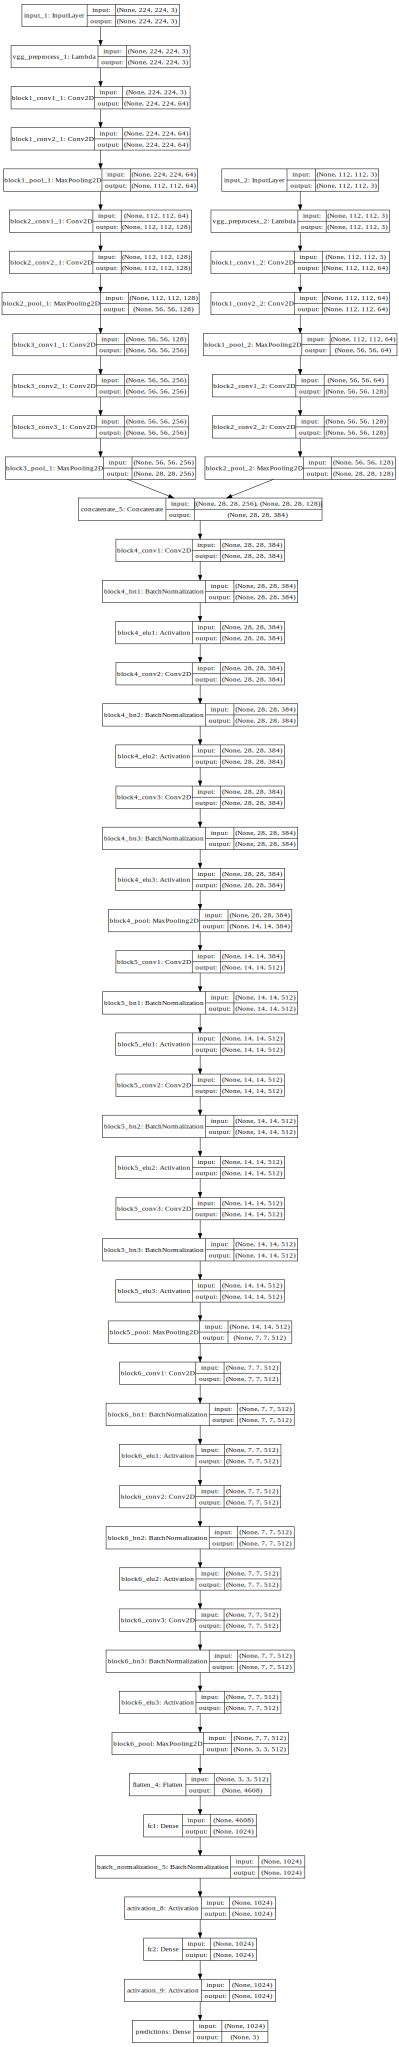

In [16]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(vgg, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
# ####################################################
#  Setup NN parameters
# ####################################################
from cv_utils import generate_trainval_kfolds
from data_utils import to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import find_best_weights_file2

seed = 54321
optimizer = 'adam'
image_size = (224, 224)

nb_epochs = 50
batch_size = 4
lr_base = 0.0003
init_epoch = 0
a = 0.957

load_best_weights = False


# ####################################################
#  Start CV
# ####################################################
from training_utils import exp_decay, step_decay

n_folds = 6
val_fold_index = 0
val_fold_indices = [0,]

hists = []

for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    save_prefix = 'custom_vgg_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get custom vgg16 model ...".format(datetime.now()))
    cnn = get_custom_vgg_bn(optimizer=optimizer, lr=lr_base)

    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename, by_name=True)

    # lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7)
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=a, init_epoch=init_epoch)
    # lrate_decay_f = None
    
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn,
              train_id_type_list,
              val_id_type_list,
              option='cervix/os', 
              normalize_data=False,
              normalization='',
              nb_epochs=nb_epochs,
              samples_per_epoch=2 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              image_size=image_size[::-1],
              seed=seed,              
              save_prefix=save_prefix)    
    if h is None:
        continue
    hists.append(h)   
    



 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-06-01 09:28:45.986041 - Get custom vgg16 model ...

 2017-06-01 09:28:49.207841 - Start training ...

-- Training parameters: 4, 50, 4776, 484

-- Fit model
- New Keras API found -
Epoch 1/50
1194/1194 [==============================] - 3290s - loss: 1.5549 - categorical_crossentropy: 1.5549 - categorical_accuracy: 0.3781 - val_loss: 1.6355 - val_categorical_crossentropy: 1.6355 - val_categorical_accuracy: 0.4360
Epoch 2/50
1194/1194 [==============================] - 1210s - loss: 1.2230 - categorical_crossentropy: 1.2230 - categorical_accuracy: 0.4024 - val_loss: 1.0118 - val_categorical_crossentropy: 1.0118 - val_categorical_accuracy: 0.4463
Epoch 3/50
1194/1194 [==============================] - 1248s - loss: 1.1237 - categorical_crossentropy: 1.1237 - categorical_accuracy: 0.4269 - val_loss: 1.0582 - v

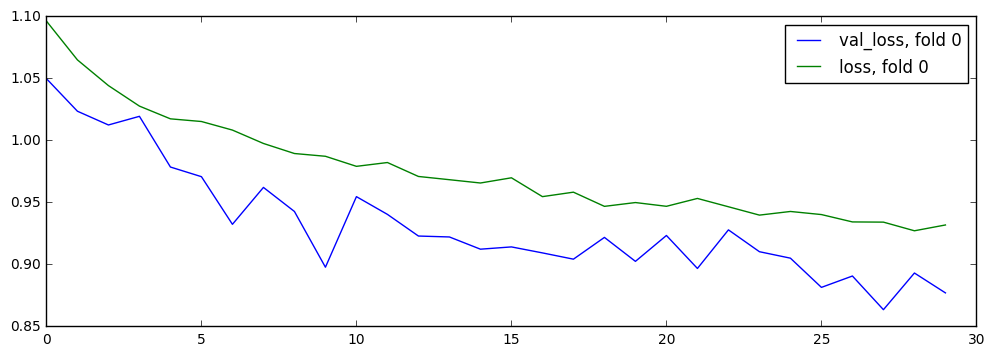

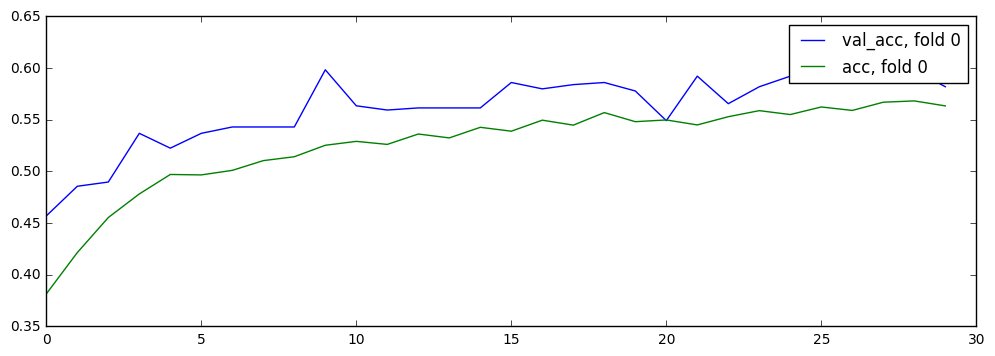

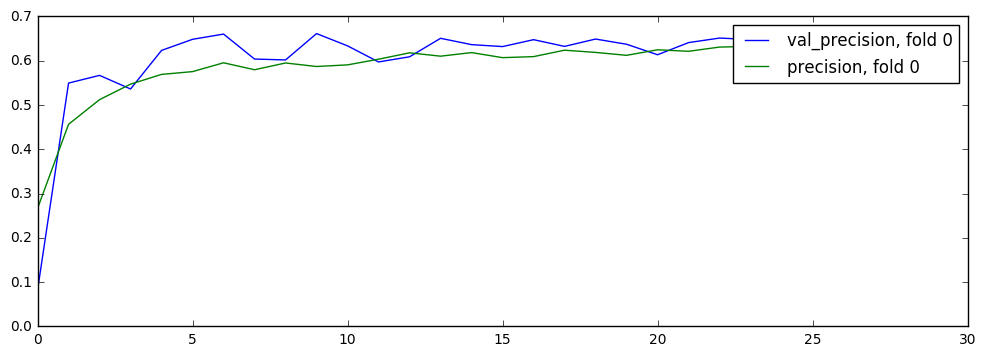

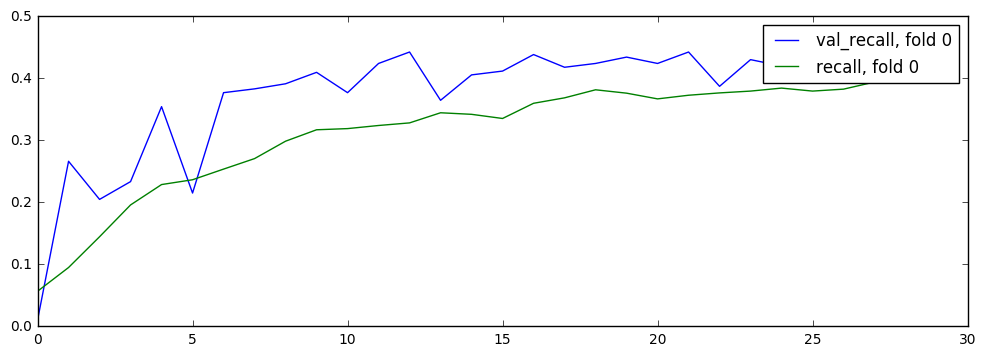

In [26]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_loss'], label='val_loss, fold %i' % i)
    plt.plot(h.history['loss'], label='loss, fold %i' % i)   
    plt.legend()


plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_acc'], label='val_acc, fold %i' % i)
    plt.plot(h.history['acc'], label='acc, fold %i' % i)   
    plt.legend()
    
plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_precision'], label='val_precision, fold %i' % i)
    plt.plot(h.history['precision'], label='precision, fold %i' % i)   
    plt.legend()
    
plt.figure(figsize=(12, 4))
ll = len(hists)
for i, h in enumerate(hists):
    plt.subplot(1, ll, i+1)
    plt.plot(h.history['val_recall'], label='val_recall, fold %i' % i)
    plt.plot(h.history['recall'], label='recall, fold %i' % i)   
    plt.legend()

In [44]:
## Cross-validation:

n_runs = 1
seed = 54321
run_counter = 0
cv_mean_losses = np.zeros((n_runs, n_folds))

while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):

        save_prefix = 'cnn_bn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        val_fold_index += 1

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
        print(compute_type_distribution(train_id_type_list))
        print(compute_type_distribution(val_id_type_list))

        print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
        cnn = get_cnn(optimizer=optimizer, lr=lr_base)

        weights_files = glob("weights/%s*.h5" % save_prefix)
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

        loss = validate(cnn, 
                        val_id_type_list, 
                        option='cervix/os',
                        normalize_data=True,
                        normalization='vgg',
                        image_size=image_size[::-1],
                        save_prefix=save_prefix,
                        batch_size=8,
                        seed=seed + run_counter,
                        verbose=1,
                        xy_provider_cache=cache)   
        cv_mean_losses[run_counter-1, val_fold_index-1] = loss
    
print(cv_mean_losses)



 ---- New run :  1 / 1


 ---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-28 11:32:13.958432 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_33_val_loss=0.8326_val_acc=0.6168_val_precision=0.6728_val_recall=0.4734.h5 0.8326
Image normalization:  vgg
Image normalization:  vgg
Total loss :  0.840584480266


 ---- Validation fold index:  1 / 6
2391 483
[0.33375156838143033, 0.32998745294855708, 0.33626097867001253]
[0.32298136645962733, 0.34575569358178054, 0.33126293995859213]

 2017-05-28 11:33:26.632550 - Get custom squeezenet model ...


AssertionError: Failed to load weights

In [45]:
np.mean(cv_mean_losses)

0.14009741337762938

In [36]:
## Predict on test data
from data_utils import test_ids

test_id_type_list = []
for image_id in test_ids:
    test_id_type_list.append((image_id, "Test"))

In [39]:
from test_utils import classification_predict as predict

predictions = []

for val_fold_index in range(n_folds):
    
    save_prefix = 'cnn_bn_os_cervix_class_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print("\n {} - Get custom squeezenet model ...".format(datetime.now()))
    cnn = get_cnn(optimizer=optimizer, lr=lr_base)

    weights_files = glob("weights/%s*.h5" % save_prefix)
    assert len(weights_files) > 0, "Failed to load weights"
    best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
    print("Load best loss weights: ", best_weights_filename, best_val_loss)
    cnn.load_weights(best_weights_filename)
    
    df = predict(cnn,
                test_id_type_list, 
                option='cervix/os', 
                normalize_data=True,
                normalization='vgg',
                image_size=image_size[::-1],
                save_prefix=save_prefix,
                batch_size=8,
                seed=seed,
                xy_provider_cache=cache)
    predictions.append(df)
    



 ---- Validation fold index:  0 / 6

 2017-05-28 11:19:40.025825 - Get custom squeezenet model ...
Load best loss weights:  weights/cnn_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_33_val_loss=0.8326_val_acc=0.6168_val_precision=0.6728_val_recall=0.4734.h5 0.8326
Image normalization:  vgg
Image normalization:  vgg
-- 0 / 512
-- 8 / 512
-- 16 / 512
-- 24 / 512
-- 32 / 512
-- 40 / 512
-- 48 / 512
-- 56 / 512
-- 64 / 512
-- 72 / 512
-- 80 / 512
-- 88 / 512
-- 96 / 512
-- 104 / 512
-- 112 / 512
-- 120 / 512
-- 128 / 512
-- 136 / 512
-- 144 / 512
-- 152 / 512
-- 160 / 512
-- 168 / 512
-- 176 / 512
-- 184 / 512
-- 192 / 512
-- 200 / 512
-- 208 / 512
-- 216 / 512
-- 224 / 512
-- 232 / 512
-- 240 / 512
-- 248 / 512
-- 256 / 512
-- 264 / 512
-- 272 / 512
-- 280 / 512
-- 288 / 512
-- 296 / 512
-- 304 / 512
-- 312 / 512
-- 320 / 512
-- 328 / 512
-- 336 / 512
-- 344 / 512
-- 352 / 512
-- 360 / 512
-- 368 / 512
-- 376 / 512
-- 384 / 512
-- 392 / 512
-- 400 / 512
-- 408 / 512
-- 416 / 512
-

AssertionError: Failed to load weights

In [40]:
import pandas as pd


def compute_mean(predictions):    
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')        
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

df = compute_mean(predictions)
df.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.208982,0.552476,0.238542
1,1.jpg,0.339248,0.552187,0.108565
2,10.jpg,0.591890,0.305741,0.102369
3,100.jpg,0.285142,0.608363,0.106496
4,101.jpg,0.389023,0.513782,0.097195


In [100]:
import pandas as pd


def compute_mean(predictions):    
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')        
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

df = compute_mean(predictions)
df.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.222587,0.533222,0.244191
1,1.jpg,0.215771,0.542684,0.241544
2,10.jpg,0.330304,0.534667,0.135029
3,100.jpg,0.300007,0.633719,0.066274
4,101.jpg,0.475317,0.412831,0.111853


In [41]:
from datetime import datetime

info = 'fold=0_squeezenet_bn'

now = datetime.now()
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
sub_file = os.path.join('..', 'results', sub_file)
df.to_csv(sub_file, index=False)

### Logs VGG16 + BN

After 30 epochs 
```
---- Validation fold index:  0 / 6
2386 483
[0.33654652137468566, 0.33319362950544845, 0.33025984911986589]
[0.30848861283643897, 0.32712215320910976, 0.36438923395445139]

 2017-05-30 00:34:10.947834 - Get custom vgg16 model ...
Load best loss weights:  weights/vgg_bn_os_cervix_class_cvfold=0_opt=adadelta_seed=54321_30_val_loss=0.8768_val_acc=0.6426_val_precision=0.6756_val_recall=0.5702.h5 0.8768

 2017-05-30 00:34:13.446721 - Start training ...

-- Training parameters: 4, 30, 4776, 484

-- Fit model
- New Keras API found -
Epoch 1/30
1194/1194 [] - 3847s - loss: 0.8539 - acc: 0.6145 - precision: 0.6669 - recall: 0.5151 - val_loss: 1.2826 - val_acc: 0.4752 - val_precision: 0.5131 - val_recall: 0.4442
Epoch 2/30
1194/1194 [] - 1906s - loss: 0.8479 - acc: 0.6225 - precision: 0.6734 - recall: 0.5224 - val_loss: 0.9195 - val_acc: 0.6116 - val_precision: 0.6584 - val_recall: 0.5455
Epoch 3/30
1194/1194 [] - 1856s - loss: 0.8222 - acc: 0.6434 - precision: 0.6907 - recall: 0.5538 - val_loss: 0.9814 - val_acc: 0.6116 - val_precision: 0.6391 - val_recall: 0.5702
Epoch 4/30
1194/1194 [] - 1840s - loss: 0.7989 - acc: 0.6539 - precision: 0.6981 - recall: 0.5685 - val_loss: 0.8642 - val_acc: 0.6426 - val_precision: 0.6584 - val_recall: 0.5909
Epoch 5/30
1194/1194 [] - 1831s - loss: 0.7903 - acc: 0.6464 - precision: 0.7021 - recall: 0.5750 - val_loss: 0.9874 - val_acc: 0.5640 - val_precision: 0.6067 - val_recall: 0.5103
Epoch 6/30
1194/1194 [] - 1828s - loss: 0.8041 - acc: 0.6464 - precision: 0.6926 - recall: 0.5664 - val_loss: 1.0631 - val_acc: 0.5496 - val_precision: 0.5689 - val_recall: 0.5124
Epoch 7/30
1194/1194 [] - 1822s - loss: 0.7912 - acc: 0.6537 - precision: 0.6933 - recall: 0.5660 - val_loss: 0.8995 - val_acc: 0.6570 - val_precision: 0.6742 - val_recall: 0.6136
Epoch 8/30
1194/1194 [] - 1823s - loss: 0.7710 - acc: 0.6621 - precision: 0.7060 - recall: 0.5913 - val_loss: 0.8912 - val_acc: 0.6488 - val_precision: 0.6825 - val_recall: 0.6054
Epoch 9/30
1194/1194 [] - 1823s - loss: 0.7588 - acc: 0.6715 - precision: 0.7142 - recall: 0.6009 - val_loss: 0.9111 - val_acc: 0.6240 - val_precision: 0.6515 - val_recall: 0.5723
Epoch 10/30
1194/1194 [] - 1823s - loss: 0.7401 - acc: 0.6845 - precision: 0.7280 - recall: 0.6101 - val_loss: 0.8669 - val_acc: 0.6426 - val_precision: 0.6722 - val_recall: 0.6095
Epoch 11/30
1194/1194 [] - 1823s - loss: 0.7367 - acc: 0.6824 - precision: 0.7233 - recall: 0.6196 - val_loss: 1.1029 - val_acc: 0.5269 - val_precision: 0.5468 - val_recall: 0.4855
Epoch 12/30
1194/1194 [] - 1823s - loss: 0.7657 - acc: 0.6633 - precision: 0.7062 - recall: 0.5907 - val_loss: 0.8952 - val_acc: 0.6095 - val_precision: 0.6412 - val_recall: 0.5579
Epoch 13/30
1194/1194 [] - 1823s - loss: 0.7417 - acc: 0.6790 - precision: 0.7235 - recall: 0.6116 - val_loss: 0.8229 - val_acc: 0.6694 - val_precision: 0.6887 - val_recall: 0.6219
Epoch 14/30
1194/1194 [] - 1821s - loss: 0.7276 - acc: 0.6834 - precision: 0.7238 - recall: 0.6248 - val_loss: 0.9171 - val_acc: 0.6302 - val_precision: 0.6522 - val_recall: 0.5992
Epoch 15/30
  48/1194 [>.............................] - ETA: 1616s - loss: 0.7771 - acc: 0.6615 - precision: 0.7135 - recall: 0.6042
```